# Predicting Car Prices with Nearest Neighbors

In this short notebook, we are going to describe how to use the **K-Nearest Neighbors** algorithm for regression on car prices.

Say we have a database of cars that have been sold and various attributes of these cars. If we get a new car in stock and want to list it, how could we determine the price?  In this notebook we'll look for the k-nearest cars, for some integer k, according to some similarity metric. Then we'll average what those k cars sold for and that we'll serve as our prediction. This we'll require a lot of data cleaning to get the data in a form so the similarity metric can be computed. We can fine-tune this model by adjusting k, the similarity metric, how we normalize our data, and what features we choose to include in our model.

<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li>Reading, Cleaning, and Preparing the Data</li>
        <li>The K-Nearest Neighbors Regressor</li>
        <li>Model and Evaluation</li>
        <li>Feature Selection</li>
        <ul><li>Hyperparameter Tuning</li><ul>
    </ul>

</div>

<hr>

## Reading and Cleaning Data

The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile) from the very useful UCI machine learning repository. You can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

cars=pd.read_csv('imports-85.data',header=None)

In [2]:
names=open('imports-85.names')
col_names=[]
pattern=r'\d\. (.*):'
for line in names:
    col=re.findall(pattern,line)
    if len(col)==1:
        col_names.append(col[0])
    

In [3]:
col_names

['Title',
 'Source Information',
 'Past Usage',
 'Relevant Information',
 'Number of Instances',
 'Number of Attributes',
 'Attribute Information',
 'symboling',
 'normalized-losses',
 'make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price',
 'Missing Attribute Values']

Looking at the column info in the `.names` file we can safely ignore the first 7 names and the last name which give information about the dataset as a whole rather than any feature of the cars themselves.

In [4]:
col_names=col_names[7:-1]

In [5]:
# Take a look at the data
cars.columns=col_names
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The columns have the following info given

1. symboling:                -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses:        continuous from 65 to 256.
3. make:                     alfa-romero, audi, bmw, chevrolet, dodge, honda,
                               isuzu, jaguar, mazda, mercedes-benz, mercury,
                               mitsubishi, nissan, peugot, plymouth, porsche,
                               renault, saab, subaru, toyota, volkswagen, volvo
4. fuel-type:                diesel, gas.
5. aspiration:               std, turbo.
6. num-of-doors:             four, two.
7. body-style:               hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels:             4wd, fwd, rwd.
9. engine-location:          front, rear.
10. wheel-base:               continuous from 86.6 120.9.
11. length:                   continuous from 141.1 to 208.1.
12. width:                    continuous from 60.3 to 72.3.
13. height:                   continuous from 47.8 to 59.8.
14. curb-weight:              continuous from 1488 to 4066.
15. engine-type:              dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders:         eight, five, four, six, three, twelve, two.
17. engine-size:              continuous from 61 to 326.
18. fuel-system:              1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore:                     continuous from 2.54 to 3.94.
20. stroke:                   continuous from 2.07 to 4.17.
21. compression-ratio:        continuous from 7 to 23.
22. horsepower:               continuous from 48 to 288.
23. peak-rpm:                 continuous from 4150 to 6600.
24. city-mpg:                 continuous from 13 to 49.
25. highway-mpg:              continuous from 16 to 54.
26. price:                    continuous from 5118 to 45400.

Price will be our target and for now we'll look at  the columns and do any cleaning necessary. For example, the `normalized-losses` column uses `?` to represent missing values. We'll replace these with `np.nan`. Let's also look at the dtypes of the columns

In [6]:
cars=cars.replace('?',np.nan)

In [7]:
cars.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [8]:
cars.columns[[1,18,19,21,22,25]]

Index(['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm',
       'price'],
      dtype='object')

Looking at the data we conclude that the columns ['normalized-lossed','bore','stroke','peak-rpm', and 'price'] can be easily converted to the `float64` type.

In [9]:
cars.iloc[:,[1,18,19,21,22,25]]=cars.iloc[:,[1,18,19,21,22,25]].astype(float)


Now let's see which columns have missing data!

In [10]:
cars.isna().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Since our target is `price` let's certainly drop any rows missing this value.

In [11]:
cars=cars.dropna(subset=['price'])

In [12]:
cars.isna().sum()

symboling             0
normalized-losses    37
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

To fill in the missing values we will group the cars by make, engine location and number of doors and impune the missing values based on the the means of these groups.

In [13]:
# impute missing values using averages after grouping by make and bodytype. 
# If the car has a unique make and body-style, take the average of its body-type.
# I.e. if it's the only Nissan sedan, just take the average of all sedans.
cars_cleaner=cars.copy()
cars_cleaner[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]=cars.groupby(['make','body-style']).transform(lambda x:x.fillna(x.mean()))[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]

In [14]:
cars_cleaner[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]=cars.groupby('body-style').transform(lambda x:x.fillna(x.mean()))[['normalized-losses', 'bore','stroke','horsepower','peak-rpm']]

In [15]:
cars_cleaner.isna().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         2
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

### Features
Now, we'll limit our features to the continuous numeric columns.

In [17]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars_cleaner[continuous_values_cols]
numeric_cars.isna().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Now finally to prepare the data for our model we will normalize all values to be between zero and one using min-max normalization.

In [18]:
# Specify the target and feature columns for the model.
target=numeric_cars['price']
features=numeric_cars.drop('price',axis=1).columns

In [19]:
# Applying min-max normalization to the features.
numeric_cars[features]=(numeric_cars[features]-numeric_cars[features].min())/(numeric_cars[features].max()-numeric_cars[features].min())

/Users/seanr/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [20]:
numeric_cars[features].head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,0.382199,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474
1,0.382199,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474
2,0.351222,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895


## The K-Nearest Neighbors Regressor

Now we will briefly discuss how one applies regression with k-nearest neighbors. Our data set has 14 numeric features ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. 

To determine whether two data-points, i.e. cars, are 'close' to one another we will use some metric. The most common metric for continuous data is the euclidean-distance (the standard notion of distance between two points in space. 

For example, let's say we restricted our features to ['engine-size', 'highway-mpg']. If we were performing 5-nearest neighbors regression with these features we would predict the new price of a car as follows. Simply find the 5 cars in the training set that are closest to the new car under the euclidean distance and take the average of their prices. This average is your predicted price! We'll demonstrate below!

### Example

In [88]:
# We'll take the first 150 points as our test-set
# The 160th car in our data set will serve as a test point. We want to predict this car's price with KNN.

example=numeric_cars.loc[:150,['engine-size','highway-mpg','price']]
test_point=numeric_cars.loc[160,['engine-size','highway-mpg','price']]

In [89]:
x0,y0,z0=test_point
# Create 'distance' column which is the squared distance from every sample in the example set from the test_point
example['distance']=(example['engine-size']-x0)**2+(example['highway-mpg']-y0)**2

In [91]:
# Find the five closest points
closest_points=example.sort_values('distance').head()
closest_points

,engine-size,highway-mpg,price,distance
90,0.158491,0.894737,7099.0,0.006589
20,0.109434,0.710526,6575.0,0.011992
19,0.109434,0.710526,6295.0,0.011992
32,0.067925,0.684211,5399.0,0.022454
76,0.116981,0.657895,5389.0,0.025443


Below, we'll try to give a visual demonstration of the NN algorithm. The red square is the new car whose price we are trying to determine. The orange triangles are the 5 nearest neighbors via the Euclidean distance. Finally, the green dots are the other cars in the test set.

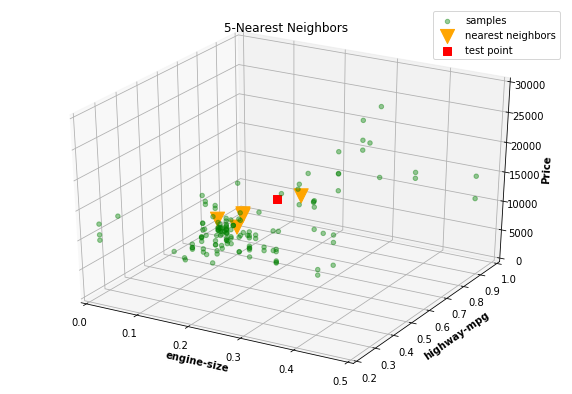

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

x=example.drop([19,20,32,76,90])['engine-size']
y=example.drop([19,20,32,76,90])['highway-mpg']
z=example.drop([19,20,32,76,90])['price']

x1=closest_points['engine-size']
y1=closest_points['highway-mpg']
z1=closest_points['price']
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
 
# Creating plot
ax.scatter3D(x,y,z, color = "green",alpha=0.4)
ax.scatter3D(x1,y1,z1,color="orange",marker='v',s=200,alpha=1)
ax.scatter3D(x0,y0,z0,color='red',marker='s',s=50)
# show plot
plt.title("5-Nearest Neighbors")
plt.xlim(0,0.5)
plt.ylim(0.2,1)
ax.set_zlim(0,30000)
ax.set_xlabel("engine-size",fontweight ='bold')
ax.set_ylabel("highway-mpg",fontweight ='bold')
ax.set_zlabel("Price",fontweight ='bold')
ax.legend(['samples','nearest neighbors','test point'])
plt.show()

The prediction for the price of the new car is simply the mean of the prices of the nearest neighbors.

In [97]:
{'prediction':closest_points['price'].mean(),'actual price':test_point['price']}

{'prediction': 6151.4, 'actual price': 7738.0}

Ok, now lets apply KNN to the whole set.
## Model and Evaluation

Now we'll try out KNN with various features and try different values for `k` as well. `k` is what's known as a hyperparameter and finding the "best" value for `k` is an example of [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

We'll use `KFold` and `cross_val_score` from `sklearn.model_selection` to assist us. This class and funtion we'll allow us to easily apply cross-validation to our model evaluation. 

`KFold` provides train/test indices to split data in train/test sets. Split dataset into l consecutive folds (without shuffling by default). Each fold is then used once as a validation while the l - 1 remaining folds form the training set.

`cross_val_score` then computes the cross validation score according to some evaluation metric. For this regression we will use the standard root mean squared error.

In [102]:
from sklearn.model_selection import cross_val_score, KFold
'''
knn_train_test applies knn regression to a dataframe with k-fold cross validation 
and returns a float,the root mean squared error.

knn_train_test takes the following argument:
    df: a pandas dataframe
    features: the columns to be used as features in the model. Must be a list even if length one.
    target: the target variable for the regression
    n: the number of neighbors (default=5)
    folds: the number of folds used in the k-fold cross validation (default=10)
'''

def knn_train_test(df,features,target,n=5,folds=10):
    
    # instantiate a KFold instance where the folds are shuffled
    
    kf=KFold(n_splits=folds,shuffle=True,random_state=1)
    
    # create the KNeighborsRegressor 
    knn=KNeighborsRegressor(n_neighbors=n,algorithm='brute')
    
    # apply cross-validation. Returns a list of mean squared errors from each fold.
    mses=cross_val_score(estimator=knn,X=df[features],y=df[target],scoring='neg_mean_squared_error',cv=kf)
    
    # take the average of the list and return this value
    avg_rsme=np.mean(np.sqrt(np.absolute(mses)))
    
    return avg_rsme

## Feature Selection

First, we'll try just one feature and 5 neighbors and see which feature picks price the best.

In [103]:
# Gives a dictionary with the feature and the average root mean squared error after cross-validation

rsmes_univariate={}
for col in numeric_cars[features].columns:
    rsme_col=knn_train_test(df=numeric_cars,features=[col],target='price')
    rsmes_univariate[col]=rsme_col
rsmes_univariate

{'normalized-losses': 6323.013399622463,
 'wheel-base': 5676.480374517227,
 'length': 5049.551484658347,
 'width': 4274.563982170558,
 'height': 7617.330945525906,
 'curb-weight': 4248.131164348986,
 'engine-size': 3022.066973616294,
 'bore': 6787.242702984874,
 'stroke': 7184.461340623811,
 'compression-ratio': 6511.23288304368,
 'horsepower': 3843.6257133375448,
 'peak-rpm': 7227.497100872575,
 'city-mpg': 4212.517293004572,
 'highway-mpg': 4272.058028231421}

In [104]:
min(rsmes_univariate.items(), key=lambda x: x[1]) 

('engine-size', 3022.066973616294)

### Hyperparameter Tuning
So for `k=5` and a single feature, it seems `engine-size` is the best predictor. Let's see if this changes as we let `k` vary.

In [105]:
#Convert above dictionaty to a Series object.
rsmes_univariate=pd.Series(rsmes_univariate).sort_values()

In [117]:
# Gives a dictionary with the feature and the average root mean squared error after cross-validation
# for various k's
ks=[1,3,5,7,9]
rsmes_univariate_k={}
for col in numeric_cars[features].columns:
    k_neighbors={}
    for k in ks:
        rsme_col=knn_train_test(df=numeric_cars,features=[col],target='price',n=k)
        k_neighbors[k]=rsme_col
    rsmes_univariate_k[col]=k_neighbors

In [119]:
rsmes_univariate_k

{'normalized-losses': {1: 6773.737662669698,
  3: 6129.283046437764,
  5: 6323.013399622463,
  7: 6878.903952452466,
  9: 7523.823920998674},
 'wheel-base': {1: 4838.811735426543,
  3: 4788.918931896196,
  5: 5676.480374517227,
  7: 5966.842431834928,
  9: 5888.137986356905},
 'length': {1: 5092.264401956441,
  3: 5230.033935409053,
  5: 5049.551484658347,
  7: 5301.361304144377,
  9: 5400.703964848575},
 'width': {1: 4990.5188305466945,
  3: 4217.846360101605,
  5: 4274.563982170558,
  7: 4408.260228765127,
  9: 4370.133823152318},
 'height': {1: 10559.769233683894,
  3: 8122.506562495744,
  5: 7617.330945525906,
  7: 7570.889893561279,
  9: 7435.227162200526},
 'curb-weight': {1: 5131.016591427542,
  3: 4585.946768732755,
  5: 4248.131164348986,
  7: 4115.152341202806,
  9: 3966.241024982434},
 'engine-size': {1: 3851.652772164489,
  3: 3264.0359997322735,
  5: 3022.066973616294,
  7: 3264.995147253416,
  9: 3479.1845889746255},
 'bore': {1: 9361.967611905924,
  3: 9261.250177810802,

Now we'll plot the results.

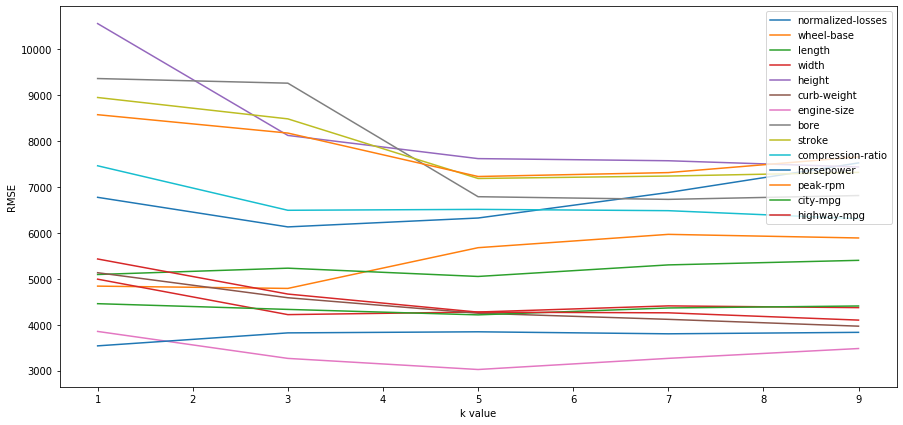

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize = (15, 7))
ax=plt.axes()
for k,v in rsmes_univariate_k.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend(labels=numeric_cars[features].columns)

So we see that except in the 1-nearest neighbor case, `engine-size` is the best univariate predictor for price!

## Mutivariate Nearest Neighbors and Feature Selection.

Now we'll see how adding more features changes the model's accuracy. These are the possible features.

In [154]:
# list of possible features in ascending oreder based on how they performed in univatiate 5-NN regression
rsmes_univariate.index

Index(['engine-size', 'horsepower', 'city-mpg', 'curb-weight', 'highway-mpg',
       'width', 'length', 'wheel-base', 'normalized-losses',
       'compression-ratio', 'bore', 'stroke', 'peak-rpm', 'height'],
      dtype='object')

How can we choose which [features](https://en.wikipedia.org/wiki/Feature_selection) to use? This is a central question to any machine learning problem. There are many techniques for this such as forwards and backwards [stepwise selection](https://en.wikipedia.org/wiki/Stepwise_regression). For our purposes we'll use the `permutation_importance` method from `sklearn.inspection` for feature selection.

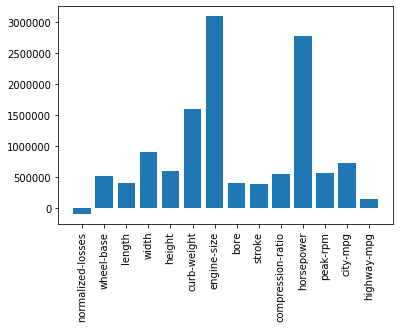

In [182]:
# permutation feature importance with knn for regression

from sklearn.inspection import permutation_importance

# data to be fit by KNN
X, y = numeric_cars[features],target
model = KNeighborsRegressor()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean

# plot feature importance
pyplot.bar([features[x] for x in range(len(importance))], importance)
plt.xticks(rotation = 90)
pyplot.show()

In [185]:
# sort features by importance
importance_dict={features[i]:v for i,v in enumerate(importance)}
importance_series=pd.Series(importance_dict)
importance_series.sort_values(axis=0,ascending=False,inplace=True)
list(importance_series.index)

['engine-size',
 'horsepower',
 'curb-weight',
 'width',
 'city-mpg',
 'height',
 'peak-rpm',
 'compression-ratio',
 'wheel-base',
 'bore',
 'length',
 'stroke',
 'highway-mpg',
 'normalized-losses']

We'll first try out different numbers of features for 5-nearest neighbors.

In [186]:
# Tries 5-nearest neighbor regression with between 2 and 10 features.
rsmes_multi={}
for i in range(2,11):
    rsme_i=knn_train_test(df=numeric_cars,features=importance_series.index[:i],target='price')
    rsmes_multi[i]=rsme_i

In [194]:
dict(sorted(rsmes_multi.items(), key=lambda item: item[1]))

{2: 2757.645736273678,
 4: 3017.748504491905,
 5: 3020.3559625631997,
 3: 3169.8429953454843,
 7: 3185.66670677813,
 8: 3194.4853197028365,
 6: 3295.6609983298536,
 9: 3387.746483247506,
 10: 3557.593992716097}

It seems that a smaller number of features performs better. We can see if this cahnges as we very the number of neighbors.

In [191]:
# Finde the cross-validated error for models varying both the number of features and neighbors up to 10.
rsmes_multivariate={}
for i in range(2,11):
    rsme_i_kneighbors={}
    for k in range(2,11):
        rsme_i_k=knn_train_test(df=numeric_cars,features=importance_series.index[:i],target='price',n=k)
        rsme_i_kneighbors[k]=rsme_i_k
    rsmes_multivariate[i]=rsme_i_kneighbors

In [192]:
# Convert dictionary to DataFrame
rsmes_multivariate=pd.DataFrame(rsmes_multivariate)

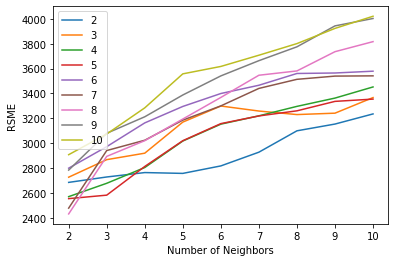

In [193]:
plt.plot(rsmes_multivariate)
plt.xlabel('Number of Neighbors')
plt.ylabel('RSME')
plt.legend(labels=rsmes_multivariate.columns)